# Разреженный автокодировщик

Вот как устроен "обычный" автокодировщик: $f(x, \omega) \rightarrow x'; \omega^* = \underset{\omega}{\operatorname{argmin}} \mathcal{L}(x', f(x, \omega))$

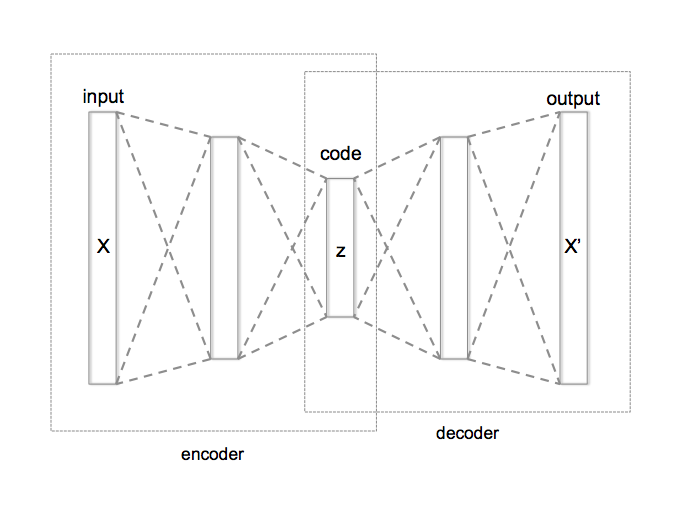

# Разреженный автокодировщик

Автокодировщики подходят для unsupervised - обучения. Привлекательно выглядит идея обучить автокодировщик на большом объеме данных, а затем использовать латентные коды $z$ как извлеченные признаки (например, при transfer learning). 

Как правило, размерность $z$ < размерности $x$. Но это не обязательно: можно использовать размерность $z$ большую, если наложить на нее дополнительную _регуляризацию_.

# Регуляция в разреженных AE

> Для регуляризации $z$ можно использовать разные "разреживающие ограничения": sparsity constraints. Мы рассмотрим применение $l_1$ и $KL$ - дивергенции.
## l1-регуляризация 

Lasso - регуляризация: $l_1 = \lambda \sum_{i=1}^k |w_i|$  
Ridge - регуляризация: $l_2 = \lambda \sum_{i=1}^k w_i^2$

> Для чего их применяют?



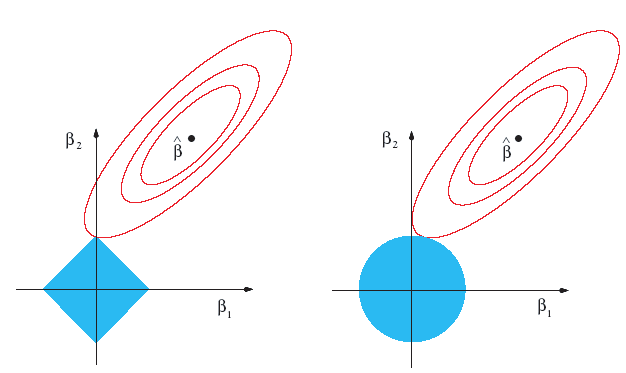

Если мы применим такую регуляризацию к $z$, мы можем получить "разреженную" репрезентацию. То есть активной (больше определенного порога) в ней будет небольшая часть нейронов. 

Это позволит получать такие репрезентации, на которых _проще_ обучаться - т.е. более полезные для нас. Есть и другие интересные свойства, о которых мы поговорим позже.

## KL-дивергенция 

Сначала - математическое ожидание для дискретного случая: $\mathcal{X} = \{x_1, x_2, \dots, x_n\}$; вероятности заданы как $P(x_i) = p_i$. Математическое ожидание тогда $\mathbb{E}[X] = \sum_{x \in \mathcal{X}} x \cdot P(x)$.

KL-дивергенция _между двумя распределениями над одним и тем же вероятностным пространством_ записывается как $D_{KL}(P||Q)$ и равна

$$D_{KL}(P||Q) = \sum_{x \in \mathcal{X}} P(x)\log{\bigg(\frac{P(X)}{Q(X)}\bigg)}$$ - или математическое ожидание по $P(X)$ разности логарифмов $P(X)$ и $Q(X)$:

![alt text](https://upload.wikimedia.org/wikipedia/commons/a/a8/KL-Gauss-Example.png)

> Как применить KL-дивергенцию для разреживания $z$?

* Задать распределение бернулии $X$ c заданной вероятностью получить $1$, равной $\hat{\rho}$. Его мат. ожидание $\mathbb{E}[X] = \hat{\rho}$.
* Представить, что нейроны в $z$ пытаются "приблизить" собой распределение Бернулии $\rho$. Т.е. они независимо (что не совсем верно) преодолевают порог активации и в таком случае считаются $"1"$. 
* Начать считать KL между распределениями $\rho$ и $\hat{\rho}$ и добавить его как регуляризацию к модели.

Тогда 

$$D_{KL}(\rho||X) = \sum_i \rho_i \log{\bigg(\frac{\rho_i}{x_i}\bigg)}$$

И в данном случае можно заменить все $x_i$ на $\mathbb{E}[X] = \hat{\rho}$, получим 

$$D_{KL}(\rho||X) = \sum_i \rho_i \log{\bigg(\frac{\rho_i}{\hat{\rho}}\bigg)}$$

Эту формулу мы будем использовать для регуляризации модели.



# Практика

In [0]:
from typing import Union, Mapping, Sized

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist


def load_mnist(shape):
    """
    Загрузка и предобработка датасета MNIST
    :param shape: целевая размерность датасета
    :return: подготовленный датасет
    """
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train / 255.
    X_test = X_test / 255.
    X_train = X_train.reshape(-1, shape)
    X_test = X_test.reshape(-1, shape)
    return (X_train, Y_train), (X_test, Y_test)


def get_sample(values, sample_size):
    """
    Извлекает заданное количество случайных сэмплов из дадасета случайным образом
    :param values: множество значений (данные)
    :param sample_size: количество значений в сэмпле
    :return: выбранное подмножетсво значений
    """
    arange = np.arange(len(values))
    idx = np.random.choice(arange, sample_size)
    return values[idx]


def get_one_item_of_each_class(values, labels):
    """
    Извлекает по одному случайному изображению для каждого из классов MNIST,
    возвращает в отсортированном порядке.
    :param values: множество значений (данные)
    :param labels: метки для данных
    :return: отсортированный по меткам набор изображений
    """
    output = []
    label_set = []
    idx = np.arange(len(values))
    np.random.shuffle(idx)
    values = values[idx]
    labels = labels[idx]
    for (val, label) in zip(values, labels):
        if label not in label_set:
            label_set.append(label)
            output.append(val)
            if len(label_set) == 10:
                break

    sorted_labels = np.argsort(label_set)
    return np.array(output)[sorted_labels]


def train_val_split(x, train_size: float):
    """
    Разделяет выборку на обучающую и валидационную.
    :param x: выборка для разделения
    :param train_size: float в диапазоне [0, 1] - размер обучающей выборки
    :return: пара (обучающая выборка, валидационная выборка)
    """
    length = len(x)
    idx = np.arange(length)
    np.random.shuffle(idx)
    train_idx = idx[:int(length * train_size)]
    val_idx = idx[int(length * train_size):]
    train = x[train_idx]
    val = x[val_idx]
    return train, val


def reconstruct_from_top_k(encoder: Model, decoder: Model, k: int,
                           images: np.array) -> np.array:
    """
    Реконструирует изображения из k наибольших активаций в латентном слое.
    :param encoder: обученный энкодер
    :param decoder: обученный декодер
    :param k: количество нейронов, котоыре не будут обнулены
    :param images: изображения для реконструкции
    :return: реконструированные изображения
    """
    latent = encoder.predict(images)
    for i in range(len(images)):
        argsort = np.argsort(latent[i])
        nullify = argsort[:-k]
        latent[i, nullify] = 0
    reconstructed = decoder.predict(latent)
    return reconstructed


def plot_reconstructed_from_top_k(images_list: Union[Mapping, Sized], 
                                  save_to: str, image_shape, n_active: int,
                                  show=False):
    """
    Реконструирует изображение, обнуляя k наименьших активаций в латентном слое
    :param images_list: набор изображений для ркконструкции
    :param save_to: путь для сохранения файла
    :param image_shape: размерность изображения
    :param n_active: количество активных нейронов
    :return: None
    """
    _, images = next(iter(images_list.items()))
    f, axes = plt.subplots(len(images_list), len(images), sharey=True)
    image_shape = [-1] + list(image_shape)

    for idx, (path_to_model, images) in enumerate(images_list.items()):
        images = images.reshape(*image_shape)
        for j, img in enumerate(images):
            axes[idx, j].matshow(img, cmap='gray')
            axes[idx, j].set_xticks([])
            axes[idx, j].set_yticks([])

            if j == 0:
                axes[idx, j].set_ylabel(f'{path_to_model.split("/")[-1]}',
                                        rotation=90,
                                        size=8)

    f.suptitle(f'Reconstructed from top {n_active} neurons from hidden layer')
    if show:
      plt.show()
    else:
      f.savefig(save_to)
      plt.close(f)

def plot_latent_unit_activation(decoder: tf.keras.Model, latent_codes, save_to,
                                image_shape, show=False):
    """
    Реконструирует и созраняет изображение по активациям латентного слоя
    :param decoder: обученный декодер
    :param latent_codes: батч латентных представлений (возможно, сгенерированный)
    :param save_to: путь изображения
    :param image_shape: размерность реконструированного изображения
    :return: None
    """
    reconstructed = decoder.predict(latent_codes)
    f, axes = plt.subplots(8, 8, sharey=True)

    image_shape = [-1] + list(image_shape)
    reconstructed = reconstructed.reshape(*image_shape)

    for i in range(8):
        for j in range(8):
            axes[i, j].matshow(reconstructed[i * 8 + j], cmap='gray')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    if show:
      plt.show()
    else:
      f.savefig(save_to)
      plt.close(f)

def plot_reconstruction(autoencoder: tf.keras.Model, images, save_to, 
                        image_shape, show=False):
    """
    Реконструирует и созраняет изображение по активациям латентного слоя
    :param autoencoder: обученный автокодировщик
    :param images: батч изображений
    :param save_to: путь изображения
    :param image_shape: размерность реконструированного изображения
    :return: None
    """
    reconstructed = autoencoder.predict(images)
    f, axes = plt.subplots(2, len(images), sharey=True)

    image_shape = [-1] + list(image_shape)
    reconstructed = reconstructed.reshape(*image_shape)
    images = images.reshape(*image_shape)

    for idx, (img, rec) in enumerate(zip(images, reconstructed)):
        title_opts = dict(y=1.1, rotation=30, size=8)
        axes[0, idx].matshow(img)
        axes[0, idx].set_title(f"Original {idx}", **title_opts)
        axes[1, idx].matshow(rec)
        axes[1, idx].set_title(f"Reconstructed {idx}", **title_opts)
        axes[0, idx].set_xticks([])
        axes[0, idx].set_yticks([])
        axes[1, idx].set_xticks([])
        axes[1, idx].set_yticks([])

    if show:
      plt.show()
    else:
      f.savefig(save_to)
      plt.close(f)


In [0]:
# import utils

# Код для создания модели и регуляризаторы активации

In [0]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.regularizers import Regularizer
import tensorflow.keras.backend as K

In [4]:
Dense(10)

In [5]:
tf.keras.layers.InputLayer()

In [0]:
def create_model(input_size: int,
                 latent_size: int,
                 activity_regularizer: Regularizer) -> Model:
    """
    Функция для создания автокодировщика.
    :param input_size: размерность входного вектора.
    :param latent_size: размерность латентного пространства.
    :param activity_regularizer: регуляризатор активации нейронов латентного слоя.
    :return: tf.keras.Model
    """
    output_size = input_size
    x = Input(shape=(input_size,), name='input')
    z = Dense(latent_size,
              activation='sigmoid',
              activity_regularizer=activity_regularizer,
              name='encoder')(x)
    r = Dense(output_size, activation='sigmoid', name='decoder')(z)
    return Model(x, r)


def load_encoder_decoder_pair(
    autoencoder: Model, path_to_weights: str = None) -> (Model, Model):
    """
    Создает из автокодировщика энкодер и декодер, используя веса модели.
    :param autoencoder: автокодировщик
    :param path_to_weights: путь до весов модели
    :return: пара (энкодер, декодер)
    """
    if path_to_weights is not None:
      autoencoder.load_weights(path_to_weights)

    encoder_layer = autoencoder.get_layer('encoder')
    decoder_layer = autoencoder.get_layer('decoder')
    input_tensor = autoencoder.get_layer('input').input

    latent_input = Input(shape=encoder_layer.output_shape[-1],
                         name='latent_input')

    z = encoder_layer(input_tensor)
    reconstructed = decoder_layer(latent_input)

    decoder = Model(latent_input, reconstructed)
    encoder = Model(input_tensor, z)
    return encoder, decoder


# For nightly build.
# More: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
# @tf.keras.utils.register_keras_serializable(package='Custom', name='KL')
class KLRegularizer(Regularizer):
    """
    KL - регуляризатор
    """
    def __init__(self, rho, alpha=1, size_average=False):
        """
        Инициализация регуляризатора с заданным ро.
        :param rho: целевая вероятность активации нейрона.
        :param size_average: усреднение лосса
        """
        self.size_average = size_average
        self.rho = rho
        self.alpha = alpha

    def __call__(self, data_rho):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        eps = K.epsilon()  # ближайшее к нулю значение типа float
        dkl = (- self.rho       * tf.math.log(eps + data_rho       / (self.rho + eps))
               - (1 - self.rho) * tf.math.log(eps + (1 - data_rho) / (1 - self.rho + eps)))
        if self.size_average:
            _rho_loss = tf.reduce_mean(dkl)
        else:
            _rho_loss = tf.reduce_sum(dkl)
        return _rho_loss * self.alpha

    def get_config(self):
        return {'rho': float(self.rho),
                'alpha': float(self.alpha),
                'size_average': self.size_average}


def make_encoder(model: Model) -> Model:
    """
    "Извлечение" энкодера из автокодировщика.
    :param model: автокодировщик
    :return: извлеченный энкодер
    """
    input = model.get_layer('input')
    encoder = model.get_layer('encoder')
    return Model(input.input, encoder.output)

# Обучение моделей

## Обычный автоэнкодер

In [0]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# from utils import load_mnist, get_sample, train_val_split, plot_reconstruction

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2760 - val_loss: 0.2533
Epoch 2/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2282 - val_loss: 0.2075
Epoch 3/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1926 - val_loss: 0.1806
Epoch 4/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1701 - val_loss: 0.1619
Epoch 5/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1542 - val_loss: 0.1487
Epoch 6/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1425 - val_loss: 0.1384
Epoch 7/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1332 - val_loss: 0.1303
Epoch 8/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1262 - val_loss: 0.1244
Epoch 9/200
750/750 [==============================] - 3s 4ms/step - loss: 0.1212 - val_loss: 0.1201
Epoch 10/200
750/750 [====

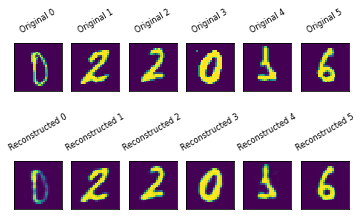

In [8]:
images = 'images'
models = 'models'
os.makedirs(images, exist_ok=True)
os.makedirs(models, exist_ok=True)

save_to = os.path.join(images, 'reconstruction_vanilla.png')
model_path = os.path.join(models, 'ae_vanilla.h5')
log_dir = 'tb_logs/vanilla'
image_shape = (28, 28)
num_classes = 10
input_size = 784
latent_size = 64
output_size = 784
sample_size = 6

"""
Создание и обучение автоэкодера без регуляризации.
"""
autoencoder = create_model(input_size, latent_size, activity_regularizer=None)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(X_train, y_train), (X_test, y_test) = load_mnist(input_size)
X, X_val = train_val_split(X_train, 0.8)

autoencoder.fit(X, X,
                validation_data=(X_val, X_val),
                epochs=200,
                batch_size=64,
                callbacks=[TensorBoard(log_dir=log_dir, histogram_freq=1),
                           ModelCheckpoint(model_path, str='val_loss', save_best_only=True),
                           EarlyStopping(patience=5, min_delta=0.0001),
                           ]
                )

sample = get_sample(X_test, sample_size)
plot_reconstruction(autoencoder, sample, save_to, (28, 28), show=True)

## l1 activity regularizer

In [0]:
from tensorflow.keras.regularizers import l1

Epoch 1/200
750/750 [==============================] - 3s 4ms/step - loss: 0.5131 - val_loss: 0.3596
Epoch 2/200
750/750 [==============================] - 3s 4ms/step - loss: 0.3381 - val_loss: 0.3213
Epoch 3/200
750/750 [==============================] - 3s 4ms/step - loss: 0.3084 - val_loss: 0.2953
Epoch 4/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2870 - val_loss: 0.2788
Epoch 5/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2704 - val_loss: 0.2631
Epoch 6/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2575 - val_loss: 0.2526
Epoch 7/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2486 - val_loss: 0.2451
Epoch 8/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2422 - val_loss: 0.2395
Epoch 9/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2372 - val_loss: 0.2352
Epoch 10/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2333 - val_lo

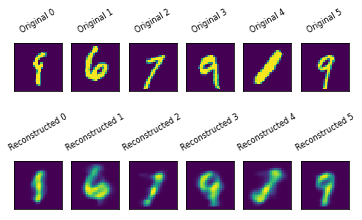

In [10]:
images = 'images'
models = 'models'
os.makedirs(images, exist_ok=True)
os.makedirs(models, exist_ok=True)

save_to = os.path.join(images, 'reconstruction_l1.png')
model_path = os.path.join(models, 'ae_l1.h5')
log_dir = 'tb_logs/l1'
image_shape = (28, 28)
num_classes = 10
input_size = 784
latent_size = 64
output_size = 784
sample_size = 6

"""
Обучение разреженного автоэкодера с l1-регуляризацией.
"""
autoencoder = create_model(input_size, latent_size, l1(0.02))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(X_train, y_train), (X_test, y_test) = load_mnist(input_size)
X, X_val = train_val_split(X_train, 0.8)

autoencoder.fit(X, X,
                validation_data=(X_val, X_val),
                epochs=200,
                batch_size=64,
                callbacks=[TensorBoard(log_dir=log_dir, histogram_freq=1),
                           ModelCheckpoint(model_path, str='val_loss', save_best_only=True),
                           EarlyStopping(patience=5, min_delta=0.0001)
                           ]
                )

sample = get_sample(X_test, sample_size)
plot_reconstruction(autoencoder, sample, save_to, (28, 28), show=True)

# KL - регуляризация

Epoch 1/200
750/750 [==============================] - 3s 4ms/step - loss: 14.1744 - val_loss: 2.0673
Epoch 2/200
750/750 [==============================] - 3s 4ms/step - loss: 1.7907 - val_loss: 1.5823
Epoch 3/200
750/750 [==============================] - 3s 4ms/step - loss: 1.5048 - val_loss: 1.4132
Epoch 4/200
750/750 [==============================] - 3s 4ms/step - loss: 1.3697 - val_loss: 1.3192
Epoch 5/200
750/750 [==============================] - 3s 4ms/step - loss: 1.2894 - val_loss: 1.2589
Epoch 6/200
750/750 [==============================] - 3s 4ms/step - loss: 1.2332 - val_loss: 1.2119
Epoch 7/200
750/750 [==============================] - 3s 4ms/step - loss: 1.1848 - val_loss: 1.1687
Epoch 8/200
750/750 [==============================] - 3s 4ms/step - loss: 1.1364 - val_loss: 1.1195
Epoch 9/200
750/750 [==============================] - 3s 4ms/step - loss: 1.0837 - val_loss: 1.0668
Epoch 10/200
750/750 [==============================] - 3s 4ms/step - loss: 1.0250 - val_l

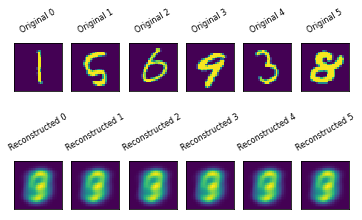

In [18]:
images = 'images'
models = 'models'
os.makedirs(images, exist_ok=True)
os.makedirs(models, exist_ok=True)

save_to = os.path.join(images, 'reconstruction_kl.png')
model_path = os.path.join(models, 'ae_kl.h5')
log_dir = 'tb_logs/kl'
image_shape = (28, 28)
num_classes = 10
input_size = 784
latent_size = 64
output_size = 784
sample_size = 6

"""
Обучение разреженного автоэкодера с KL-регуляризацией.
"""
autoencoder = create_model(input_size, latent_size, KLRegularizer(0.001, alpha=10))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(X_train, y_train), (X_test, y_test) = load_mnist(input_size)
X, X_val = train_val_split(X_train, 0.8)

autoencoder.fit(X, X,
                validation_data=(X_val, X_val),
                epochs=200,
                batch_size=64,
                callbacks=[TensorBoard(log_dir=log_dir, histogram_freq=1),
                            ModelCheckpoint(model_path, str='val_loss',
                                            save_best_only=True,
                                            save_weights_only=True),
                            # EarlyStopping(patience=5, min_delta=0.0001)
                            ]
                )

sample = get_sample(X_test, sample_size)
plot_reconstruction(autoencoder, sample, save_to, (28, 28), show=True)


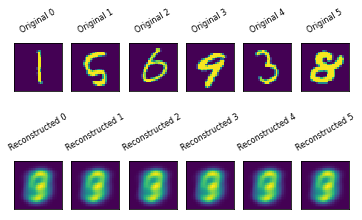

In [19]:
plot_reconstruction(autoencoder, sample, save_to, (28, 28), show=True)

# Сравнение моделей

## Распределения активаций разных моделей

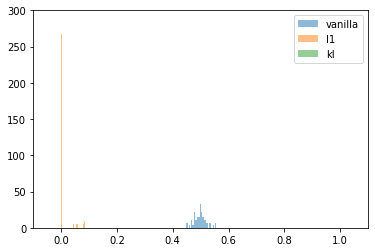

In [25]:
"""
Сравнение распределений активации нейронов в латентном слое.
"""
model_kl = create_model(input_size, latent_size, KLRegularizer(0.02))
model_kl.load_weights('models/ae_kl.h5')
model_vanilla = tf.keras.models.load_model('models/ae_vanilla.h5')
model_l1 = tf.keras.models.load_model('models/ae_l1.h5')

models = {'vanilla': model_vanilla, 'l1': model_l1, 'kl': model_kl}
models = {k: make_encoder(m) for k, m in models.items()}

(X_train, y_train), (X_test, y_test) = load_mnist(input_size)

for directory, model in models.items():
    values = model.predict(X_test)
    values = values.mean(axis=0)
    plt.hist(values, bins=25, alpha=0.5,
             label=directory, stacked=True,
             density=True, )
plt.ylim(0, 300)
plt.xlim(-0.1, 1.1)
plt.legend(loc='upper right')
plt.savefig('images/hidden_activations.png')


## Создание изображения по one-hot вектору активации

In [0]:
autoencoder = create_model(input_size, latent_size, activity_regularizer=None)
_, decoder = load_encoder_decoder_pair(autoencoder, 'models/ae_l1.h5')

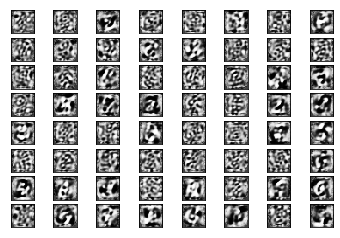

In [24]:
"""
Сохраняет рекоструированные изображения по одному на каждый активный нейрон.  
"""
latent_codes = np.eye(64)
plot_latent_unit_activation(decoder, latent_codes, 
                            'images/generated_images_l1.png', image_shape,
                            show=True)

## Реконструкция по top-k активаций

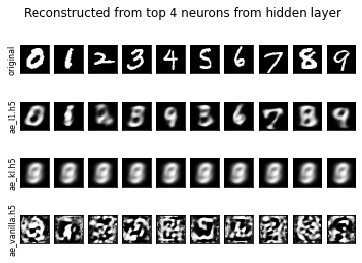

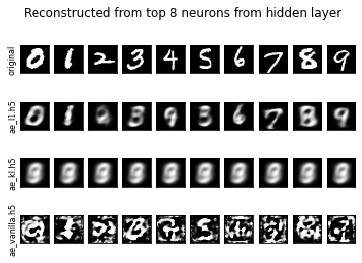

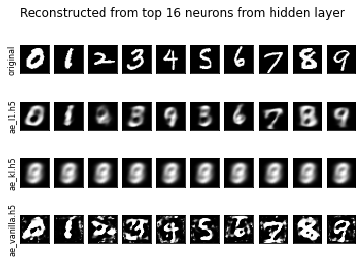

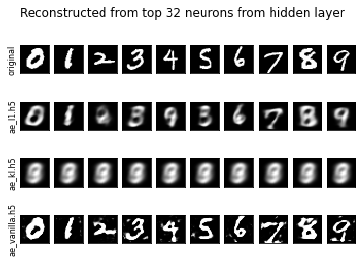

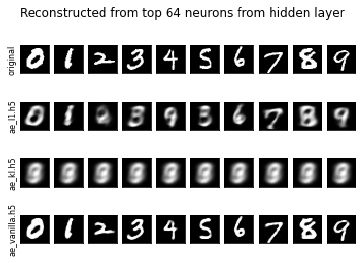

In [23]:
"""
Скрипт строит графики с реконструкцией по k максимальным активациям 
латентного слоя.
"""
autoencoder = create_model(input_size, latent_size, None)
(X_train, y_train), (X_test, y_test) = load_mnist(input_size)
sample = get_one_item_of_each_class(X_test, y_test)
k_active_neurons = (4, 8, 16, 32, 64)

for active_neurons in k_active_neurons:
    image_map = {'original': sample}
    for path in ('models/ae_l1.h5', 'models/ae_kl.h5', 'models/ae_vanilla.h5'):
        encoder, decoder = load_encoder_decoder_pair(autoencoder, path)
        reconstructed = reconstruct_from_top_k(encoder, decoder, 
                                               active_neurons, sample)
        image_map[path] = reconstructed
    plot_reconstructed_from_top_k(image_map,
                                  f'images/neurons_active_{active_neurons}.png',
                                  (28, 28),
                                  active_neurons,
                                  show=True)